# Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append('../..')

from pathlib import Path

In [2]:
%autoreload


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib
matplotlib.rc_file('matplotlibrc')
matplotlib.rcParams['figure.figsize'] = [10,10]


# SET THIS TO TRUE TO USE LATEX
matplotlib.rcParams['text.usetex'] = True

from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

from astropy.io import fits


# np.set_printoptions(threshold=np.nan)

# Load Transfer Functions

In [3]:
standard_tfs = False
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfs_20190120/'

string_fixed_xe = 'standard_xe_xHe_full_rs'
string_with_xHe_0 = 'xHe0'
string_with_xHe = 'full_xHe'

################# Standard xe Transfer Functions ##############################
# This is a TransferFuncList
# highengphot_tflist_fixed_xe = pickle.load(open(direc+'tfunclist_photspec_60eV_complete_'+string_fixed_xe+'.raw','rb'))
# highengphot_tflist_fixed_xe = highengphot_tflist_fixed_xe[0]

################# xHe=0 Transfer Functions ####################################
# highengphot_tflist_xHe_0 = pickle.load(open(direc+'tfunclist_photspec_60eV_complete_'+string_with_xHe_0+'.raw', 'rb'))

xes_xHe_0 = 0.5 + 0.5*np.tanh(
    [-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]
)

################# Full xHe-Dependent Transfer Functions #######################

# highengphot_tflist_arr_with_xHe = pickle.load(open(direc+'tfunclist_photspec_60eV_complete_'+string_with_xHe+'.raw', 'rb'))

xes_with_xHe = 0.5 + 0.5*np.tanh(
    np.array(
        [-5.0, -2.3, -0.5, 0.0, 0.4, 2.2, 4.0]
    )
)

x_arr_with_xHe = np.array([[[xH, xHe] for xHe in xes_with_xHe] for xH in xes_with_xHe])

#######################################################################
# Inputs for main.load_trans_funcs
#######################################################################

direc_arr = ['/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfs_20190120/' for i in np.arange(3)]
xes = [x_arr_with_xHe, xes_xHe_0, None]
string_arr = [string_with_xHe, string_with_xHe_0, string_fixed_xe]

# direc_arr = ['/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfs_20190120/' for i in np.arange(2)]
# xes = [xes_xHe_0, None]
# string_arr = [string_with_xHe_0, string_fixed_xe]

CMB_subtracted = False

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(
        direc_arr, xes, 
#         rs_nodes = np.array([1600]),
        rs_nodes = np.array([40, 1600]),
        string_arr=string_arr, CMB_subtracted=CMB_subtracted)


Loading transfer functions, set 0
Loaded high energy photons...
Low energy photons...
Low energy electrons...
High energy deposition...
CMB losses.
Transfer function lists set  0  complete.
Padding transfer functions...
High energy photons...
Low energy photons...
Low energy electrons...
High energy deposition...
CMB losses...
Creating array objects...
Generating TransferFuncInterp object...
Loading transfer functions, set 1
Loaded high energy photons...
Low energy photons...
Low energy electrons...
High energy deposition...
CMB losses.
Transfer function lists set  1  complete.
Padding transfer functions...
High energy photons...
Low energy photons...
Low energy electrons...
High energy deposition...
CMB losses...
Creating array objects...
Generating TransferFuncInterp object...
Loading transfer functions, set 2
Loaded high energy photons...
Low energy photons...
Low energy electrons...
High energy deposition...
CMB losses.
Transfer function lists set  2  complete.
Padding transfer fun

# ICS Transfer Functions

In [4]:
direc = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/"
ics_file = Path(direc+"ics_thomson_ref_tf.raw")

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open(direc+"ics_thomson_ref_tf.raw", "rb"))
    ics_rel_ref_tf = pickle.load(open(direc+"ics_rel_ref_tf.raw", "rb"))
    engloss_ref_tf = pickle.load(open(direc+"engloss_ref_tf.raw", "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open(direc+"ics_thomson_ref_tf.raw", "wb"))
    pickle.dump(ics_rel_ref_tf, open(direc+"ics_rel_ref_tf.raw", "wb"))
    pickle.dump(engloss_ref_tf, open(direc+"engloss_ref_tf.raw", "wb"))

# Energy Injection Parameters

In [5]:
#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'photon'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# IDL Data

In [6]:
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/ref_files/z_3000_phot_decay_recfast/'

hdul = fits.open(
    direc
    +'tf_z_3.000E+03_nstep_6398_logE_1.230E+01_xe_0.000E+00.fits'
)
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

# IDL $f(z)$ Results

In [8]:
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/ref_files/z_3000_phot_decay_recfast/idl_calculated_fs/'

log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(39)])
print(log10eng[37])
# # log10eng[-1] = np.log10(highengphot_tf_interp.eng[-1])*.99
# log10eng[-1]*=.99

eng = log10eng

float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
f_idl_list_low  = np.zeros((len(eng),5,6398))
f_idl_list_high = np.zeros((len(eng),5,6398))
for i, en in enumerate(eng):
    hdul = fits.open(
        direc+'calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
        +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
    )

    data = hdul[1].data

    f_idl_low  = data.field('loweng_deposition_fractions')[0]
    f_idl_high = data.field('higheng_deposition_fractions')[0]
    idl_redshift     = data.field('redshift')[0]

#     f_idl_list[i,:] = f_idl_low + f_idl_high
    f_idl_list_low[i,:,:] = f_idl_low
    f_idl_list_high[i,:,:] = f_idl_high

    hdul.close()
    
# Pull out the correct index for comparison
f_idl_list_compare_low  = f_idl_list_low[37, :, :]
f_idl_list_compare_high = f_idl_list_high[37, :, :] 


12.302416909421996


# Run DarkHistory

In [9]:
#injection energy, DM mass, center-of-mass energy
%autoreload 

tau=.5e25
sigmav=0
end_rs = 5
start_rs = 3000

photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

Einj = 10**log10eng[37]
mDM = 2*Einj + 2*mass
print(np.log10(mDM))
Ecom=mDM

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)

if inj_type == 'swave':
    mDM = mDM/2
    Ecom = 2*mDM   

if inj_particle == 'electron':
    Etmp = eleceng[eleceng < Einj][-1]
    elec_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/Etmp]),
        np.array([Etmp]),
        eleceng
    )
    elec_spec_init.rs = start_rs
    elec_spec_init.switch_spec_type()

    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=start_rs)
else:
    Etmp = photeng[photeng < Einj][-1]
    phot_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/Etmp]),
        np.array([Etmp]),
        photeng
    )
    phot_spec_init.rs = start_rs
    phot_spec_init.switch_spec_type()

    elec_spec_init = Spectrum(eleceng,
                             np.zeros_like(eleceng),
                             spec_type='N',
                             rs=start_rs)

f_DH_list = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=1, std_soln=True,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
    use_tqdm=True
)

12.603446905085978


../../darkhistory/history/tla.py:212: RuntimeWarning: overflow encountered in cosh
  return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
../../darkhistory/history/tla.py:185: RuntimeWarning: overflow encountered in cosh
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
../../darkhistory/history/tla.py:185: RuntimeWarning: invalid value encountered in double_scalars
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
../../darkhistory/history/tla.py:212: RuntimeWarning: overflow encountered in double_scalars
  return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
../../darkhistory/history/tla.py:185: RuntimeWarning: overflow encountered in double_scalars
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
../../darkhistory/history/tla.p

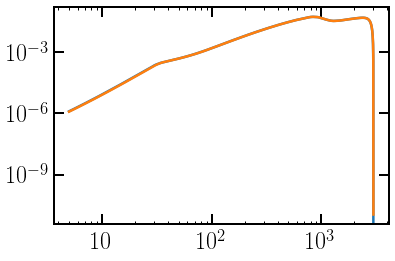

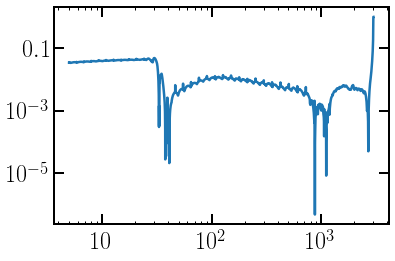

In [10]:
f_DH = f_DH_list[6]

plt.figure()
ax = plt.gca()
ax.loglog()

rs_list = f_DH_list[2].rs[1:]

chan = 0

plt.plot(rs_list, f_DH[0][:,chan])
plt.plot(idl_redshift[1:], f_idl_list_compare_low[chan,1:])

plt.figure()
ax = plt.gca()
ax.loglog()

plt.plot(idl_redshift[1:],np.abs(1 - f_DH[0][:, chan]/f_idl_list_compare_low[chan,1:]))

In [11]:
print(rs_list)
print(idl_redshift)

[2997.0014995  2994.005996   2991.01348651 ...    5.00965759    5.00465044
    4.99964829]
[3000.         2997.0014995  2994.005996   ...    5.00965759    5.00465044
    4.99964829]


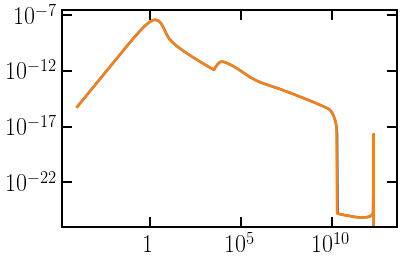

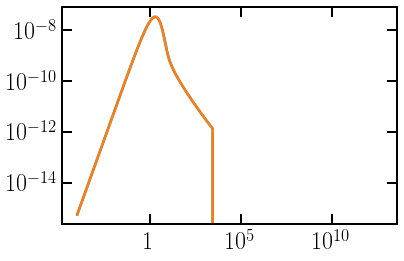

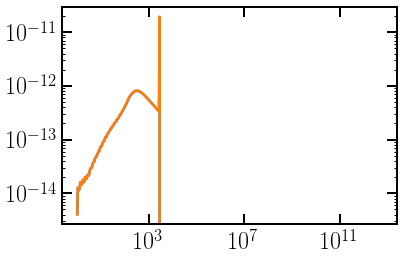

In [12]:
highengphot_spectra = f_DH_list[2]
lowengphot_spectra  = f_DH_list[3]
lowengelec_spectra  = f_DH_list[4]

plt.figure()
ax = plt.gca()
ax.loglog()

highengphot_spectra.plot(ax, ind=34)
plt.plot(idl_energy, idl_photonspectrum[34]*idl_bin_width)

plt.figure()
ax = plt.gca()
ax.loglog()

lowengphot_spectra.plot(ax, ind=34)
plt.plot(idl_energy, idl_lowengphot[34]*idl_bin_width)

plt.figure()
ax = plt.gca()
ax.loglog()

lowengelec_spectra.plot(ax, ind=34)
plt.plot(idl_eleceng, idl_lowengelec[34]*idl_elec_bin_width)


# lowengphot_spectra.plot(ax, ind=4)
# lowengelec_spectra.plot(ax, ind=3)

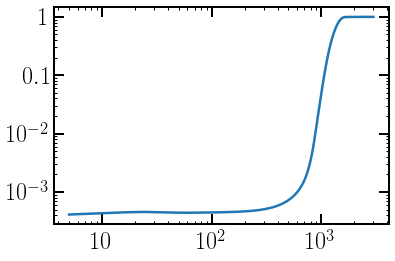

In [13]:
plt.figure()

ax = plt.gca()
ax.loglog()

plt.plot(rs_list, f_DH_list[0][:,0])
# plt.plot(rs_list, f_DH_list[1])

In [14]:
f_DH_list[0]

array([[1.00000000e+00, 9.98875841e-01],
       [9.99999997e-01, 9.98837687e-01],
       [9.99999997e-01, 9.98798191e-01],
       ...,
       [4.11245083e-04, 0.00000000e+00],
       [4.11217153e-04, 0.00000000e+00],
       [4.11189236e-04, 0.00000000e+00]])